# Homework 5 — SVM on LFW (Linear & RBF) + Optional PCA
### CAP 4630 - Artificial Intelligence - FALL 2025

**Name:** Xavier Andres Soto Baron
**UCF ID:** 5601517

This starter notebook is intentionally **incomplete**. Your tasks include:
- Load **LFW** (identities ≥ 50 images) and build a **60/15/25** train/val/test split (fixed seed).
- Implement evaluation utilities and tuning loops for **Linear SVM** and **RBF SVM**.
- (Optional) Add **PCA → SVM** experiments.
- Report **validation-selected** hyperparameters and **test accuracy**.

> You **may** use scikit-learn (e.g., `SVC`, `Pipeline`, `StandardScaler`, `PCA`).
> 
> **Important:** Tune hyperparameters on the **validation** set only; after choosing best params, retrain on **train+val** and evaluate once on **test**.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1) Load LFW people (min_faces_per_person=50) and flatten

**Provided** so everyone uses the same filtered dataset.

**Hint:** This may download on first run.

In [30]:
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.4, color=False)
X_images = lfw.images                 # (n_samples, h, w)
X = lfw.data.astype(np.float32)       # (n_samples, h*w)
y = lfw.target                        # integer labels
target_names = lfw.target_names       # label -> name mapping
h, w = lfw.images.shape[1:3]

print("Images:", X_images.shape, "| Flattened:", X.shape, "| Labels:", y.shape)
print("Num classes:", len(target_names), "Names:", list(target_names))

Images: (1560, 50, 37) | Flattened: (1560, 1850) | Labels: (1560,)
Num classes: 12 Names: [np.str_('Ariel Sharon'), np.str_('Colin Powell'), np.str_('Donald Rumsfeld'), np.str_('George W Bush'), np.str_('Gerhard Schroeder'), np.str_('Hugo Chavez'), np.str_('Jacques Chirac'), np.str_('Jean Chretien'), np.str_('John Ashcroft'), np.str_('Junichiro Koizumi'), np.str_('Serena Williams'), np.str_('Tony Blair')]


## 2) Visualize some faces (optional but recommended)

Use the helper below to display a few samples to sanity-check the data and labels.

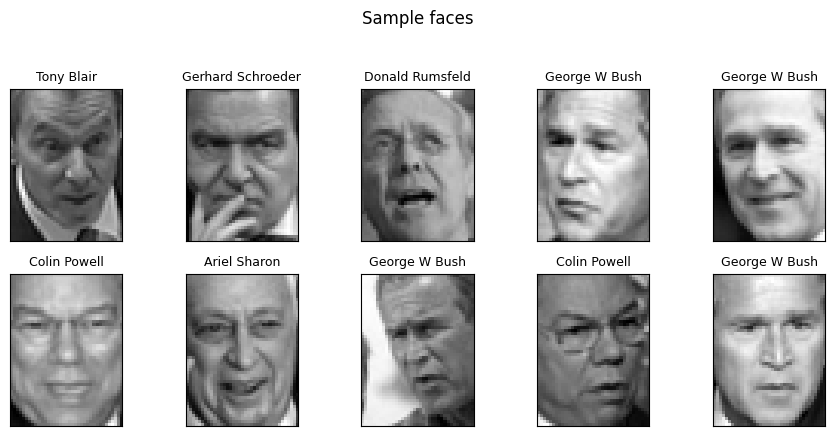

In [31]:
def plot_faces(images, labels, label_names, n_row=2, n_col=5, title=None):
    plt.figure(figsize=(1.8*n_col, 2.2*n_row))
    if title:
        plt.suptitle(title)
    for i in range(n_row*n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(str(label_names[labels[i]]), fontsize=9)
        plt.xticks([]); plt.yticks([])
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Uncomment to preview
plot_faces(X_images[:10], y[:10], target_names, n_row=2, n_col=5, title="Sample faces")

## 3) Stratified split: 60% train / 15% val / 25% test

**Provided** code for the two-stage split; keep the same seed for fairness and reproducibility.

**Hint:** Use `stratify=` so class proportions are preserved in splits.

In [32]:
# Step 1: train+val vs test (25% test)
X_trval, X_te, y_trval, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
# Step 2: train vs val (20% of trval -> 15% overall)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_trval, y_trval, test_size=0.20, stratify=y_trval, random_state=RANDOM_STATE
)
print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_te.shape)

Train: (936, 1850) Val: (234, 1850) Test: (390, 1850)


## 4) Utilities — **YOU implement** evaluation & plots

**TODO A:** Implement `evaluate_model` that:
1. **Fits** the model on **TRAIN** only.
2. Predicts on **VAL** and **TEST**.
3. Returns a dict with `val_acc`, `test_acc`, and predictions.

**TODO B (optional):** Implement `show_confusion` to display a confusion matrix.

**Hints:**
- Use `accuracy_score` from `sklearn.metrics`.
- Return a dict so you can compare results across hyperparameters.
- Keep function signatures unchanged for reuse later.

In [33]:
def evaluate_model(clf, X_tr, y_tr, X_val, y_val, X_te, y_te, label=""):
    # Fit model on training data
    clf.fit(X_tr, y_tr)

    # Predict on validation and test sets
    val_pred = clf.predict(X_val)
    test_pred = clf.predict(X_te)

    # Compute accuracies
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_te, test_pred)

    # Print formatted summary
    print(f"[{label}] Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

    # Return dictionary for later comparisons
    return {
        "val_acc": val_acc,
        "test_acc": test_acc,
        "val_pred": val_pred,
        "test_pred": test_pred
    }

def show_confusion(y_true, y_pred, label_names, title="Confusion matrix"):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=label_names,
        xticks_rotation=90,
        cmap="Blues"
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 5) Linear SVM — **YOU implement** tuning over C on validation

**Goal:** Build a pipeline `StandardScaler → SVC(kernel='linear')` and tune **C** on the validation set.

**TODO C:** Write the loop over a small grid of `C` values, call `evaluate_model`, and track the best by **validation accuracy**.

**TODO D:** After selecting the best `C`, **retrain on TRAIN+VAL** and evaluate once on **TEST**.

**Hints:**
- Use `Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='linear', C=C))])`.
- For retraining on train+val, stack arrays: `np.vstack([X_tr, X_val])`, `np.hstack([y_tr, y_val])`.
- Keep a clear printout of your chosen best C and corresponding accuracies.
- Example grid: `[0.01, 0.1, 1, 10, 100]` (you can adjust).

[C=0.01] Val Acc: 0.7991 | Test Acc: 0.8103
[C=0.1] Val Acc: 0.7991 | Test Acc: 0.8077
[C=1] Val Acc: 0.7991 | Test Acc: 0.8077
[C=10] Val Acc: 0.7991 | Test Acc: 0.8077
[C=100] Val Acc: 0.7991 | Test Acc: 0.8077

Best Linear SVM found: C=0.01 | Val Acc=0.7991
Final Linear SVM — C=0.01 | Test Accuracy=0.8308


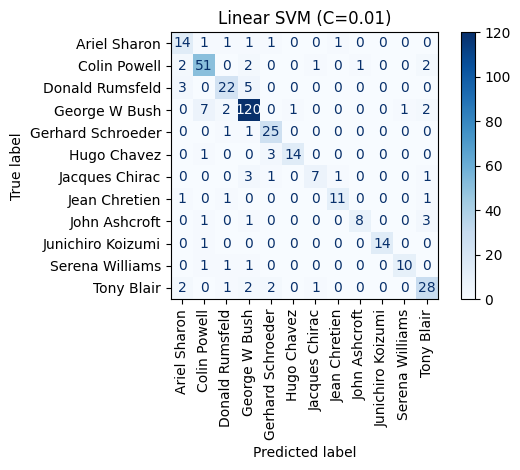

In [35]:
C_grid_linear = [0.01, 0.1, 1, 10, 100]  # you may modify

best_linear = None
best_C = None
best_val_acc = -1.0

for C in C_grid_linear:
    # Build pipeline: scaler → linear SVM
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("svm", SVC(kernel="linear", C=C, random_state=RANDOM_STATE))
    ])
    
    # Evaluate using helper
    metrics = evaluate_model(pipe, X_tr, y_tr, X_val, y_val, X_te, y_te, label=f"C={C}")
    
    # Track best model by validation accuracy
    if metrics["val_acc"] > best_val_acc:
        best_val_acc = metrics["val_acc"]
        best_C = C
        best_linear = pipe

print(f"\nBest Linear SVM found: C={best_C} | Val Acc={best_val_acc:.4f}")

# Retrain best Linear SVM on TRAIN+VAL and evaluate on TEST
X_trval = np.vstack([X_tr, X_val])
y_trval = np.concatenate([y_tr, y_val])

final_linear = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("svm", SVC(kernel="linear", C=best_C, random_state=RANDOM_STATE))
])

final_linear.fit(X_trval, y_trval)
test_pred_linear = final_linear.predict(X_te)
test_acc_linear = accuracy_score(y_te, test_pred_linear)

print(f"Final Linear SVM — C={best_C} | Test Accuracy={test_acc_linear:.4f}")

# (Optional) Confusion matrix
show_confusion(y_te, test_pred_linear, target_names, title=f"Linear SVM (C={best_C})")



## 6) RBF SVM — **YOU implement** tuning over C and gamma on validation

**Goal:** Build `StandardScaler → SVC(kernel='rbf')` and tune over a grid of **C** and **gamma**.

**TODO E:** Write the nested loop over C and gamma, call `evaluate_model`, and track the best pair by **validation accuracy**.

**TODO F:** After selecting the best `(C, gamma)`, **retrain on TRAIN+VAL** and evaluate once on **TEST**.

**Hints:**
- Start with a small grid, then expand near the best region if needed.
- Example grids: `C in [0.1, 1, 10, 100]`, `gamma in ['scale', 0.001, 0.01, 0.1]` (you may adjust).

[C=0.1, γ=scale] Val Acc: 0.3376 | Test Acc: 0.3410
[C=0.1, γ=0.001] Val Acc: 0.3376 | Test Acc: 0.3410
[C=0.1, γ=0.01] Val Acc: 0.3376 | Test Acc: 0.3410
[C=0.1, γ=0.1] Val Acc: 0.3376 | Test Acc: 0.3410
[C=1, γ=scale] Val Acc: 0.6667 | Test Acc: 0.6282
[C=1, γ=0.001] Val Acc: 0.6068 | Test Acc: 0.5872
[C=1, γ=0.01] Val Acc: 0.3376 | Test Acc: 0.3410
[C=1, γ=0.1] Val Acc: 0.3376 | Test Acc: 0.3410
[C=10, γ=scale] Val Acc: 0.7863 | Test Acc: 0.7667
[C=10, γ=0.001] Val Acc: 0.7009 | Test Acc: 0.6821
[C=10, γ=0.01] Val Acc: 0.3376 | Test Acc: 0.3410
[C=10, γ=0.1] Val Acc: 0.3376 | Test Acc: 0.3410
[C=100, γ=scale] Val Acc: 0.7863 | Test Acc: 0.7667
[C=100, γ=0.001] Val Acc: 0.7009 | Test Acc: 0.6821
[C=100, γ=0.01] Val Acc: 0.3376 | Test Acc: 0.3410
[C=100, γ=0.1] Val Acc: 0.3376 | Test Acc: 0.3410

Best RBF SVM found: C=10, γ=scale | Val Acc=0.7863
Final RBF SVM — C=10, γ=scale | Test Accuracy=0.8026


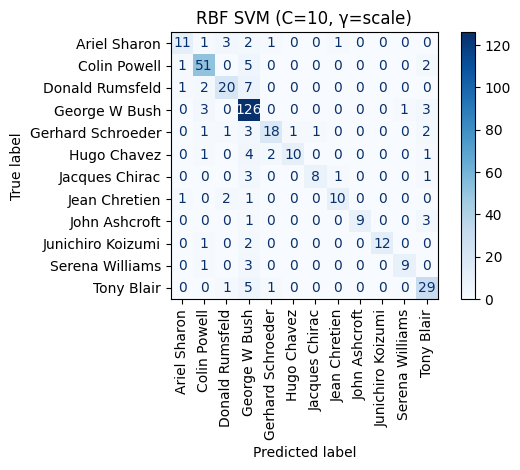

In [36]:
C_grid_rbf = [0.1, 1, 10, 100]            # you may modify
gamma_grid = ["scale", 0.001, 0.01, 0.1]  # you may modify

best_rbf = None
best_params_rbf = None
best_val_acc_rbf = -1.0

# (TODO E) Nested loop over (C, gamma)
for C in C_grid_rbf:
    for gamma in gamma_grid:
        # Build pipeline: StandardScaler → RBF SVM
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True)),
            ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=RANDOM_STATE))
        ])

        # Evaluate using helper
        metrics = evaluate_model(pipe, X_tr, y_tr, X_val, y_val, X_te, y_te, label=f"C={C}, γ={gamma}")

        # Track best model by validation accuracy
        if metrics["val_acc"] > best_val_acc_rbf:
            best_val_acc_rbf = metrics["val_acc"]
            best_params_rbf = (C, gamma)
            best_rbf = pipe

print(f"\nBest RBF SVM found: C={best_params_rbf[0]}, γ={best_params_rbf[1]} | Val Acc={best_val_acc_rbf:.4f}")

# (TODO F) Retrain best RBF SVM on TRAIN+VAL and evaluate on TEST
X_trval = np.vstack([X_tr, X_val])
y_trval = np.concatenate([y_tr, y_val])

best_C, best_gamma = best_params_rbf

final_rbf = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("svm", SVC(kernel="rbf", C=best_C, gamma=best_gamma, random_state=RANDOM_STATE))
])

final_rbf.fit(X_trval, y_trval)
test_pred_rbf = final_rbf.predict(X_te)
test_acc_rbf = accuracy_score(y_te, test_pred_rbf)

print(f"Final RBF SVM — C={best_C}, γ={best_gamma} | Test Accuracy={test_acc_rbf:.4f}")

# (Optional) visualize confusion matrix
show_confusion(y_te, test_pred_rbf, target_names, title=f"RBF SVM (C={best_C}, γ={best_gamma})")


## 7) (Optional) PCA → SVM — **YOU implement**

**Goal:** Insert `PCA` before SVM (Linear and/or RBF). Choose `k` via a target variance ratio.

**TODO G:**
1. Fit a temporary PCA on **TRAIN** only to compute cumulative explained variance and select `k` for a target ratio (e.g., 0.95).
2. Build a pipeline `StandardScaler → PCA(n_components=k) → SVC(...)`.
3. Repeat tuning (C for Linear; C & gamma for RBF) using the **validation** set.
4. Retrain the best PCA+SVM model(s) on **TRAIN+VAL** and evaluate once on **TEST**.

**Hints:**
- Use `PCA(svd_solver='full', whiten=False, random_state=RANDOM_STATE)`.
- Compute `k` with `np.cumsum(pca_tmp.explained_variance_ratio_)` and `np.searchsorted`.
- Report `k`, chosen hyperparameters, and test accuracy.
- Be careful to avoid data leakage: fit PCA only on training data.

PCA: retaining ~95% variance ⇒ k=153 components

=== PCA + Linear SVM ===
[PCA-Linear C=0.01] Val Acc: 0.7863 | Test Acc: 0.7923
[PCA-Linear C=0.1] Val Acc: 0.7650 | Test Acc: 0.7872
[PCA-Linear C=1] Val Acc: 0.7650 | Test Acc: 0.7872
[PCA-Linear C=10] Val Acc: 0.7650 | Test Acc: 0.7872
[PCA-Linear C=100] Val Acc: 0.7650 | Test Acc: 0.7872
Best PCA+Linear SVM: C=0.01 | Val Acc=0.7863
Final PCA+Linear SVM — Test Accuracy=0.8205

=== PCA + RBF SVM ===
[PCA-RBF C=0.1, γ=scale] Val Acc: 0.3376 | Test Acc: 0.3410
[PCA-RBF C=0.1, γ=0.001] Val Acc: 0.3376 | Test Acc: 0.3410
[PCA-RBF C=0.1, γ=0.01] Val Acc: 0.3376 | Test Acc: 0.3410
[PCA-RBF C=0.1, γ=0.1] Val Acc: 0.3376 | Test Acc: 0.3410
[PCA-RBF C=1, γ=scale] Val Acc: 0.6795 | Test Acc: 0.6487
[PCA-RBF C=1, γ=0.001] Val Acc: 0.6368 | Test Acc: 0.6179
[PCA-RBF C=1, γ=0.01] Val Acc: 0.3376 | Test Acc: 0.3410
[PCA-RBF C=1, γ=0.1] Val Acc: 0.3376 | Test Acc: 0.3410
[PCA-RBF C=10, γ=scale] Val Acc: 0.7949 | Test Acc: 0.7769
[PCA-RBF C=10, γ=0.00

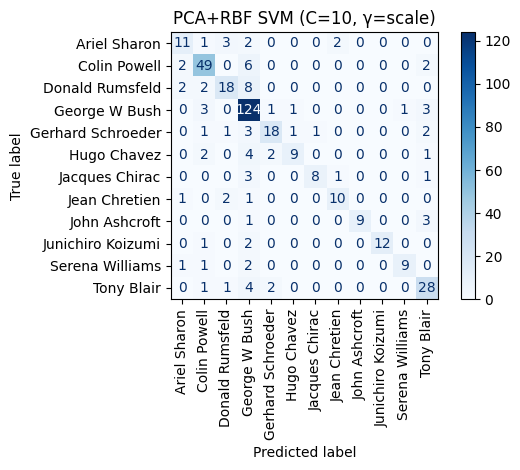

In [38]:
use_pca = True   # set True to run PCA experiments
variance_ratio = 0.95

if use_pca:
    #### Determine k from TRAIN only (target variance ratio) ####
    pca_tmp = PCA(svd_solver='full', whiten=False, random_state=RANDOM_STATE)
    pca_tmp.fit(X_tr)
    cum = np.cumsum(pca_tmp.explained_variance_ratio_)
    k = int(np.searchsorted(cum, variance_ratio) + 1)
    print(f"PCA: retaining ~{variance_ratio*100:.0f}% variance ⇒ k={k} components")

    #### Build pipelines with PCA + SVM; tune on VAL; retrain on TR+VAL; evaluate on TEST ####

    # --- PCA + Linear SVM ---
    print("\n=== PCA + Linear SVM ===")
    C_grid_linear = [0.01, 0.1, 1, 10, 100]
    best_lin_pca = None
    best_C_lin_pca = None
    best_val_acc_lin_pca = -1.0

    for C in C_grid_linear:
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True)),
            ("pca", PCA(n_components=k, svd_solver='full', whiten=False, random_state=RANDOM_STATE)),
            ("svm", SVC(kernel="linear", C=C, random_state=RANDOM_STATE))
        ])
        metrics = evaluate_model(pipe, X_tr, y_tr, X_val, y_val, X_te, y_te, label=f"PCA-Linear C={C}")
        if metrics["val_acc"] > best_val_acc_lin_pca:
            best_val_acc_lin_pca = metrics["val_acc"]
            best_C_lin_pca = C
            best_lin_pca = pipe

    print(f"Best PCA+Linear SVM: C={best_C_lin_pca} | Val Acc={best_val_acc_lin_pca:.4f}")

    # Retrain best PCA+Linear on TRAIN+VAL and evaluate on TEST
    X_trval = np.vstack([X_tr, X_val])
    y_trval = np.concatenate([y_tr, y_val])
    final_lin_pca = Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("pca", PCA(n_components=k, svd_solver='full', whiten=False, random_state=RANDOM_STATE)),
        ("svm", SVC(kernel="linear", C=best_C_lin_pca, random_state=RANDOM_STATE))
    ])
    final_lin_pca.fit(X_trval, y_trval)
    test_pred_lin_pca = final_lin_pca.predict(X_te)
    test_acc_lin_pca = accuracy_score(y_te, test_pred_lin_pca)
    print(f"Final PCA+Linear SVM — Test Accuracy={test_acc_lin_pca:.4f}")

    # --- PCA + RBF SVM ---
    print("\n=== PCA + RBF SVM ===")
    C_grid_rbf = [0.1, 1, 10, 100]
    gamma_grid = ["scale", 0.001, 0.01, 0.1]
    best_rbf_pca = None
    best_params_rbf_pca = None
    best_val_acc_rbf_pca = -1.0

    for C in C_grid_rbf:
        for gamma in gamma_grid:
            pipe = Pipeline([
                ("scaler", StandardScaler(with_mean=True)),
                ("pca", PCA(n_components=k, svd_solver='full', whiten=False, random_state=RANDOM_STATE)),
                ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=RANDOM_STATE))
            ])
            metrics = evaluate_model(pipe, X_tr, y_tr, X_val, y_val, X_te, y_te, label=f"PCA-RBF C={C}, γ={gamma}")
            if metrics["val_acc"] > best_val_acc_rbf_pca:
                best_val_acc_rbf_pca = metrics["val_acc"]
                best_params_rbf_pca = (C, gamma)
                best_rbf_pca = pipe

    print(f"Best PCA+RBF SVM: C={best_params_rbf_pca[0]}, γ={best_params_rbf_pca[1]} | Val Acc={best_val_acc_rbf_pca:.4f}")

    # Retrain best PCA+RBF on TRAIN+VAL and evaluate on TEST
    best_C_pca, best_gamma_pca = best_params_rbf_pca
    final_rbf_pca = Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("pca", PCA(n_components=k, svd_solver='full', whiten=False, random_state=RANDOM_STATE)),
        ("svm", SVC(kernel="rbf", C=best_C_pca, gamma=best_gamma_pca, random_state=RANDOM_STATE))
    ])
    final_rbf_pca.fit(X_trval, y_trval)
    test_pred_rbf_pca = final_rbf_pca.predict(X_te)
    test_acc_rbf_pca = accuracy_score(y_te, test_pred_rbf_pca)
    print(f"Final PCA+RBF SVM — Test Accuracy={test_acc_rbf_pca:.4f}")

    # (Optional) Confusion matrix visualization
    show_confusion(y_te, test_pred_rbf_pca, target_names, title=f"PCA+RBF SVM (C={best_C_pca}, γ={best_gamma_pca})")

else:
    print("Skipped PCA experiments. Set use_pca=True to enable.")


## 8) What to include in your PDF report
- Final **test accuracy** for:
  - Linear SVM (best C)
  - RBF SVM (best C, gamma)
  - (Optional) PCA + SVM variants (report k)
- The **chosen hyperparameters** (selected by validation accuracy)
- Short discussion of how **C** and **gamma** affected performance
- If PCA used: effect on accuracy and runtime
- (Optional) confusion matrices for best models

**Tip:** Keep code and results well organized so we can follow your steps.